In [1]:
import cv2
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Dataset
from torchvision.transforms import CenterCrop
from tqdm import tqdm

import os

In [2]:
# Определяем параметры обучения
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 12
# Определяем размеры изображения
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128
# Определяем трешхолд
THRESHOLD = 0.5
# Определяем лямбду для подсчета лосса
LAMBDA = 0.5
# Определяем пути к директориям
BASE_FOLDER = os.curdir
MODEL_FOLDER = os.path.join(BASE_FOLDER, "models")
# Определяем пути к модели
MODEL_PATH = os.path.join(MODEL_FOLDER, "unet_leaf_segmentation.pth")
PLOT_PATH = os.path.sep.join([BASE_FOLDER, "plots/plot.png"])
# Определяем базовый путь к датасету
DATASET_PATH = os.path.join(os.path.curdir, "aug_data")
# Определяем путь к датасетам
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")
# Определяем процент тестовой выборки
TEST_SPLIT = 0.15
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False
print(DEVICE)

In [6]:
from torch.utils.data import Dataset
import cv2
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    def __len__(self):
        return len(self.imagePaths)
    def __getitem__(self, idx):
        imagePath = self.imagePaths[idx]
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], cv2.IMREAD_UNCHANGED)
        if len(mask.shape) == 3:
            mask = mask[:,:,-1]
        else:
            mask = 1 * (mask > 0)
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
        return (image, mask)

transformes = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((INPUT_IMAGE_HEIGHT,
    INPUT_IMAGE_WIDTH)),
    torchvision.transforms.ToTensor()])

In [7]:
from imutils import paths
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Получаем списки изображений и масок
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))
# Делим на тестовую и обучающую выборку
split = train_test_split(imagePaths, maskPaths,
	test_size=TEST_SPLIT, random_state=42)
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
    transforms=transformes)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transformes)
trainLoader = DataLoader(trainDS, shuffle=True,
    batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY)
testLoader = DataLoader(testDS, shuffle=False,
    batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY)

In [8]:
class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # Объявляем линейные слои с прослойкой из relu
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # Применяем описанный выше блок
        return self.conv2(self.relu(self.conv1(x)))
    
class Encoder(Module):
    def __init__(self, in_channels=3, channels=(16, 32, 64)):
        super().__init__()
        # Объявляем блоки энкодера с макспуллом
        channels = (in_channels,) + channels
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)
    def forward(self, x):
        # Объявляем выходы блоков
        blockOutputs = []
        # Проходимся по блокам энкодера
        for block in self.encBlocks:
            # Пропускаем х через очередной блок
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        # Возвращаем список выходов
        return blockOutputs
    
class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
                for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)])
    def forward(self, x, encFeatures):
        # Проходимся по каждому из каналов
        for i in range(len(self.channels) - 1):
            # передаем входные данные через блоки дискретизатора
            x = self.upconvs[i](x)
            # пропускаем через блок декодера
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        # Возвращаем итог
        return x
    def crop(self, encFeatures, x):
        # Оберзаем картинку
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # возвращаем обрезанную картинку
        return encFeatures

class UNet(Module):
    def __init__(self, inChannels=3, encChannels=(16, 32, 64),
        decChannels=(64, 32, 16),
        nbClasses=1, retainDim=True,
        outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        super().__init__()
        # Объявляем энкодер и декодер
        self.encoder = Encoder(inChannels, encChannels)
        self.decoder = Decoder(decChannels)
        encChannels = (inChannels,) + encChannels
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
    def forward(self, x):
        # Пропускаем x через энкодер
        encFeatures = self.encoder(x)
        # Пропускаем результат через декодер
        decFeatures = self.decoder(encFeatures[::-1][0],
            encFeatures[::-1][1:])
        map = self.head(decFeatures)
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # Возвращаем полученную маску
        return map

In [9]:
def reduce_loss(loss, reduction):
    """Reduce loss as specified.
    Args:
        loss (Tensor): Elementwise loss tensor.
        reduction (str): Options are "none", "mean" and "sum".
    Return:
        Tensor: Reduced loss tensor.
    """
    reduction_enum = F._Reduction.get_enum(reduction)
    if reduction_enum == 0:
        return loss
    elif reduction_enum == 1:
        return loss.mean()
    elif reduction_enum == 2:
        return loss.sum()

def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 0.001
    pred = torch.sigmoid(pred)
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

def weight_reduce_loss(loss, weight=None, reduction='mean', avg_factor=None):
    """Apply element-wise weight and reduce loss.
    Args:
        loss (Tensor): Element-wise loss.
        weight (Tensor): Element-wise weights.
        reduction (str): Same as built-in losses of PyTorch.
        avg_factor (float): Average factor when computing the mean of losses.
    Returns:
        Tensor: Processed loss values.
    """
    if weight is not None:
        loss = loss * weight

    if avg_factor is None:
        loss = reduce_loss(loss, reduction)
    else:
        if reduction == 'mean':
            eps = torch.finfo(torch.float32).eps
            loss = loss.sum() / (avg_factor + eps)
    return loss

def lossFunc(pred, target, weight=None, gamma=2.0, alpha=0.25, reduction='mean', avg_factor=None):
    pred_sigmoid = pred.sigmoid()
    target = target.type_as(pred)
    pt = (1 - pred_sigmoid) * target + pred_sigmoid * (1 - target)
    focal_weight = (alpha * target + (1 - alpha) *
                    (1 - target)) * pt.pow(gamma)
    loss = F.binary_cross_entropy_with_logits(
        pred, target, reduction='none') * focal_weight
    loss = weight_reduce_loss(loss, weight, reduction, avg_factor)
    return loss

def get_loss(pred, y):
    fu = (lossFunc(pred, (y != 0) * 1.) * (1 - LAMBDA))
    dice = dice_loss(pred, y) * LAMBDA
    return  fu + dice

In [10]:
unet = UNet().to(DEVICE)
opt = Adam(unet.parameters(), lr=INIT_LR)
H = {"train_loss": [], "test_loss": []}

In [180]:
# вычисляем шаги за эпоху для обучающего и тестового датасета
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# Цикл по эпохам
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    unet.train()
    totalTrainLoss = 0
    totalTestLoss = 0
    for (i, (x, y)) in enumerate(trainLoader):
        # Посылаем x и y на девайс
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # Получаем преположение модели и считаем лосс
        pred = unet(x)
        loss = get_loss(pred, (y != 0) * 1.)
        # сначала обнулим все ранее накопленные градиенты, затем
        # выполним обратное распространение, а затем обновим параметры модели
        opt.zero_grad()
        loss.backward()
        opt.step()
        totalTrainLoss += loss
    # отключаем подсчет градиента
    with torch.no_grad():
        unet.eval()
        for (x, y) in testLoader:
            # Отправляем x и y на девайс
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # Получаем предсказания модели и считаем лосс
            pred = unet(x)
            totalTestLoss += get_loss(pred, (y != 0) * 1.)
    # Считаем средний лосс
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # Добавляем текущий лосс
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # Выводим информацию об эпохе
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
# Выводим общее время обучения
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))

[INFO] training the network...


  2%|▎         | 1/40 [01:13<47:28, 73.04s/it]

[INFO] EPOCH: 1/40
Train loss: 0.215344, Test loss: 0.2367


  5%|▌         | 2/40 [02:25<45:56, 72.53s/it]

[INFO] EPOCH: 2/40
Train loss: 0.206580, Test loss: 0.2247


  8%|▊         | 3/40 [03:36<44:21, 71.94s/it]

[INFO] EPOCH: 3/40
Train loss: 0.193621, Test loss: 0.2209


 10%|█         | 4/40 [04:47<42:55, 71.54s/it]

[INFO] EPOCH: 4/40
Train loss: 0.183475, Test loss: 0.1936


 12%|█▎        | 5/40 [05:58<41:39, 71.41s/it]

[INFO] EPOCH: 5/40
Train loss: 0.177427, Test loss: 0.1929


 15%|█▌        | 6/40 [07:09<40:21, 71.23s/it]

[INFO] EPOCH: 6/40
Train loss: 0.176827, Test loss: 0.1938


 18%|█▊        | 7/40 [08:18<38:50, 70.61s/it]

[INFO] EPOCH: 7/40
Train loss: 0.176569, Test loss: 0.1885


 20%|██        | 8/40 [09:28<37:26, 70.19s/it]

[INFO] EPOCH: 8/40
Train loss: 0.172560, Test loss: 0.1840


 22%|██▎       | 9/40 [10:37<36:08, 69.94s/it]

[INFO] EPOCH: 9/40
Train loss: 0.168665, Test loss: 0.1884


 25%|██▌       | 10/40 [11:47<34:54, 69.82s/it]

[INFO] EPOCH: 10/40
Train loss: 0.168044, Test loss: 0.1803


 28%|██▊       | 11/40 [12:56<33:42, 69.73s/it]

[INFO] EPOCH: 11/40
Train loss: 0.162917, Test loss: 0.1743


 30%|███       | 12/40 [14:05<32:30, 69.65s/it]

[INFO] EPOCH: 12/40
Train loss: 0.162304, Test loss: 0.1718


 32%|███▎      | 13/40 [15:15<31:18, 69.56s/it]

[INFO] EPOCH: 13/40
Train loss: 0.161137, Test loss: 0.1723


 35%|███▌      | 14/40 [16:24<30:08, 69.56s/it]

[INFO] EPOCH: 14/40
Train loss: 0.161394, Test loss: 0.1745


 38%|███▊      | 15/40 [17:34<28:58, 69.55s/it]

[INFO] EPOCH: 15/40
Train loss: 0.159570, Test loss: 0.1721


 40%|████      | 16/40 [18:44<27:50, 69.59s/it]

[INFO] EPOCH: 16/40
Train loss: 0.158593, Test loss: 0.1689


 42%|████▎     | 17/40 [19:53<26:40, 69.58s/it]

[INFO] EPOCH: 17/40
Train loss: 0.156622, Test loss: 0.1732


 45%|████▌     | 18/40 [21:03<25:32, 69.68s/it]

[INFO] EPOCH: 18/40
Train loss: 0.155987, Test loss: 0.1651


 48%|████▊     | 19/40 [22:13<24:23, 69.68s/it]

[INFO] EPOCH: 19/40
Train loss: 0.155008, Test loss: 0.1705


 50%|█████     | 20/40 [23:23<23:14, 69.74s/it]

[INFO] EPOCH: 20/40
Train loss: 0.154399, Test loss: 0.1620


 52%|█████▎    | 21/40 [24:32<22:04, 69.70s/it]

[INFO] EPOCH: 21/40
Train loss: 0.152745, Test loss: 0.1686


 55%|█████▌    | 22/40 [25:42<20:53, 69.67s/it]

[INFO] EPOCH: 22/40
Train loss: 0.153819, Test loss: 0.1669


 57%|█████▊    | 23/40 [26:51<19:44, 69.66s/it]

[INFO] EPOCH: 23/40
Train loss: 0.150223, Test loss: 0.1613


 60%|██████    | 24/40 [28:01<18:35, 69.70s/it]

[INFO] EPOCH: 24/40
Train loss: 0.149741, Test loss: 0.1625


 62%|██████▎   | 25/40 [29:11<17:25, 69.72s/it]

[INFO] EPOCH: 25/40
Train loss: 0.148804, Test loss: 0.1627


 65%|██████▌   | 26/40 [30:21<16:16, 69.77s/it]

[INFO] EPOCH: 26/40
Train loss: 0.146445, Test loss: 0.1613


 68%|██████▊   | 27/40 [31:31<15:06, 69.75s/it]

[INFO] EPOCH: 27/40
Train loss: 0.146623, Test loss: 0.1796


 70%|███████   | 28/40 [32:40<13:56, 69.75s/it]

[INFO] EPOCH: 28/40
Train loss: 0.148839, Test loss: 0.1657


 72%|███████▎  | 29/40 [33:50<12:47, 69.77s/it]

[INFO] EPOCH: 29/40
Train loss: 0.148938, Test loss: 0.1602


 75%|███████▌  | 30/40 [35:01<11:39, 69.97s/it]

[INFO] EPOCH: 30/40
Train loss: 0.146153, Test loss: 0.1573


 78%|███████▊  | 31/40 [36:11<10:31, 70.12s/it]

[INFO] EPOCH: 31/40
Train loss: 0.144617, Test loss: 0.1631


 80%|████████  | 32/40 [37:22<09:22, 70.34s/it]

[INFO] EPOCH: 32/40
Train loss: 0.143897, Test loss: 0.1570


 82%|████████▎ | 33/40 [38:33<08:12, 70.41s/it]

[INFO] EPOCH: 33/40
Train loss: 0.139330, Test loss: 0.1571


 85%|████████▌ | 34/40 [39:43<07:02, 70.35s/it]

[INFO] EPOCH: 34/40
Train loss: 0.140991, Test loss: 0.1644


 88%|████████▊ | 35/40 [40:53<05:51, 70.22s/it]

[INFO] EPOCH: 35/40
Train loss: 0.143711, Test loss: 0.1568


 90%|█████████ | 36/40 [42:03<04:40, 70.16s/it]

[INFO] EPOCH: 36/40
Train loss: 0.139601, Test loss: 0.1548


 92%|█████████▎| 37/40 [43:13<03:30, 70.17s/it]

[INFO] EPOCH: 37/40
Train loss: 0.137537, Test loss: 0.1586


 95%|█████████▌| 38/40 [44:23<02:20, 70.18s/it]

[INFO] EPOCH: 38/40
Train loss: 0.139637, Test loss: 0.1589


 98%|█████████▊| 39/40 [45:33<01:10, 70.16s/it]

[INFO] EPOCH: 39/40
Train loss: 0.139737, Test loss: 0.1577


100%|██████████| 40/40 [46:43<00:00, 70.10s/it]

[INFO] EPOCH: 40/40
Train loss: 0.139188, Test loss: 0.1568
[INFO] total time taken to train the model: 2803.92s


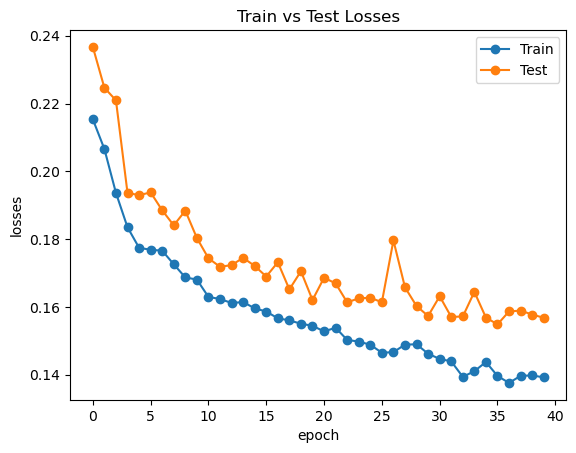

In [181]:
# Построение графика
plt.plot(H["train_loss"],'-o')
plt.plot(H["test_loss"],'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')

# Сохранение графика и модели
plt.savefig(PLOT_PATH)
torch.save(unet.to("cpu"), MODEL_PATH)